In [719]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
sys.path.append("../../python")

import matplotlib.pyplot as plt
import numpy as np
import scipy

from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
reload(parser)
reload(datatypes)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

## About

Check the reconstruction quality of hadronicly decaying LLP

Plots:

* number of tracks
* number of vertex
* number of tracks of the vertex with most tracks in each event
* number of tracklets (with 1,2,3+ hits) of the vertex with most tracks in each event
* track residual and pull distribution
* vertex residual and pull distribution
* track chi2/ndof and chi2 prob
* vertex chi2/ndof and chi2 prob


## Commands

Before running this test, you should go to the make_llp.ipynb to generate LLP signal.

```bash
# Suppose you are in the ./build folder of the current project.
# Make a new folder to save data for this test
data_dir="../../musim_test/recon_llp/"
seed=1
mkdir -p $data_dir

# Run simulation + digitization + reconstruction
run=0
./simulation -s $seed -r $run -m ../tests/filereader_generator/run_filereader.mac -o $data_dir 
./digitizer $data_dir/run_${run}.root -s $seed -p 10  -n 27.4
./tracker $data_dir/run_${run}_digi.root -r $data_dir/run_${run}.root -k 1 -p 10  

# Run the recreate generator on the result to test if the result could be reproduced
run=1
./simulation -r $run -m ../tests/filereader_generator/run_recreate.mac -o $data_dir 
./digitizer $data_dir/run_${run}.root -s $seed -p 10  
./tracker $data_dir/run_${run}_digi.root -r $data_dir/run_${run}.root -k 1 -p 10  


# Run 25 GeV
run=2
./simulation -s $seed -r $run -m ../tests/filereader_generator/run_filereader-25GeV.mac -o $data_dir 
./digitizer $data_dir/run_${run}.root -s $seed -p 10  -n 27.4
./tracker $data_dir/run_${run}_digi.root -r $data_dir/run_${run}.root -k 1 -p 10  

```

In [743]:
data_dir="../../../musim_test/recon_llp/"
fname_recon = f"{data_dir}/run_2_digi_recon.root"
# fname_recon_reproduce = f"{data_dir}/run_1_digi_recon.root"

In [744]:
f1 = root.tfile_reader(fname_recon)
f1.ls()

## Get metadata
f1.get_tree("metadata;2")
# f1.ls_tree()
metadata_digi = f1.get_entry(0)

f1.get_tree("data")
# f1.ls_tree()
f1.get_entry(0);

None
TFile**		../../../musim_test/recon_llp//run_2_digi_recon.root	
 TFile*		../../../musim_test/recon_llp//run_2_digi_recon.root	
  KEY: TTree	data;3	Reconstruction Tree [current cycle]
  KEY: TTree	data;2	Reconstruction Tree [backup cycle]
  KEY: TTree	metadata;3	Simulation metadata [current cycle]
  KEY: TTree	metadata;2	Metadata for digitization [backup cycle]
  KEY: TTree	metadata;1	Metadata for reconstruction [backup cycle]


In [745]:
data = f1.get_entry(0)
print(data.keys())

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_edep', 'Hit_px', 'Hit_py', 'Hit_pz', 'Hit_trackID', 'Hit_trackIDparent', 'Hit_pdgID', 'Hit_pdgIDparent', 'Hit_isprimary', 'Hit_processID', 'Hit_detectorID', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Step_x', 'Step_y', 'Step_z', 'Step_t', 'Step_edep', 'Step_px', 'Step_py', 'Step_pz', 'Step_trackID', 

4


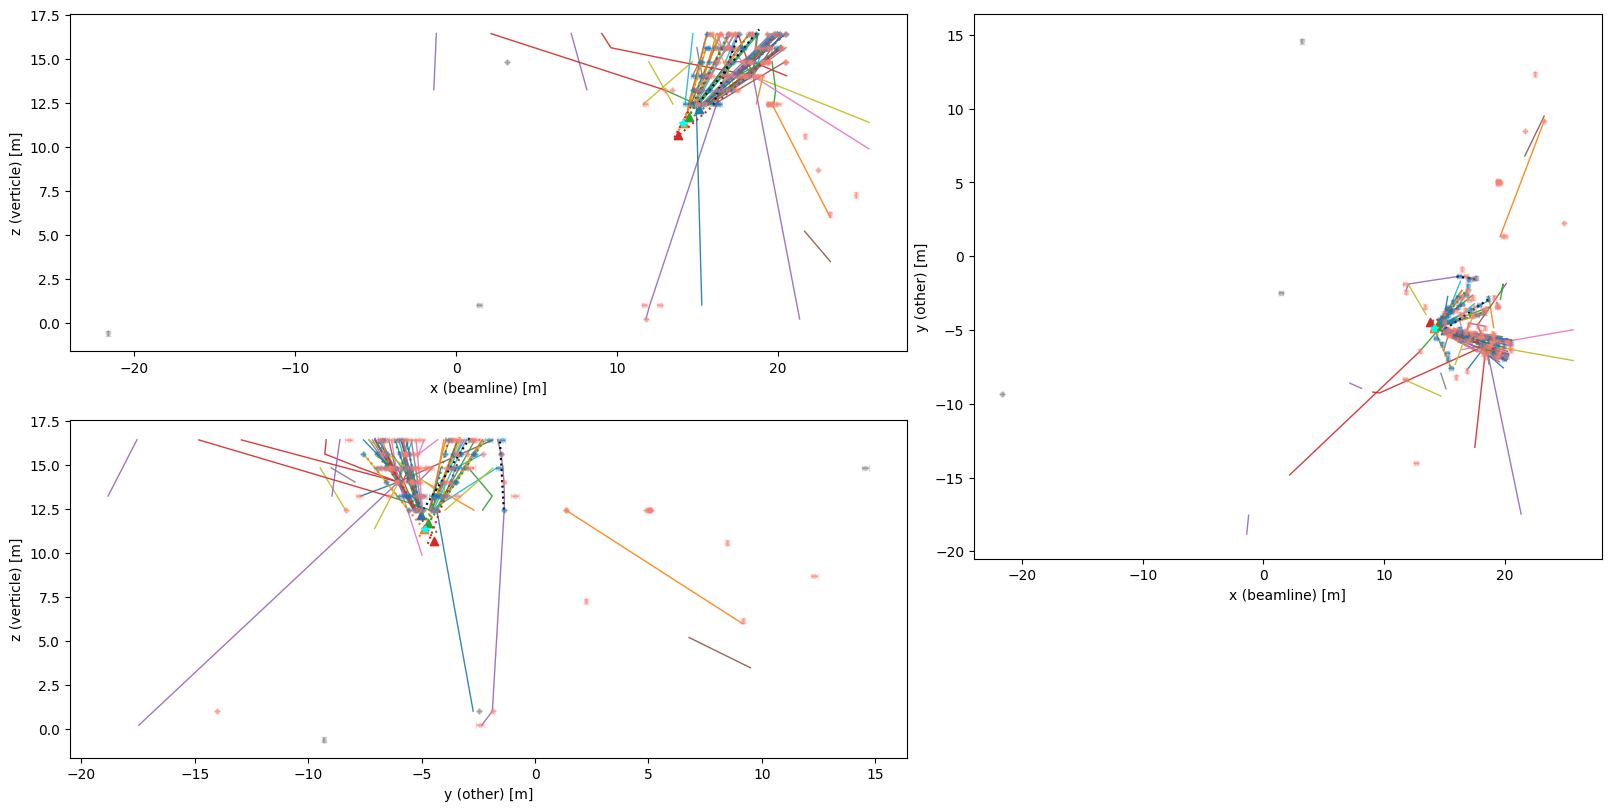

In [746]:
# i=15
i+=1
print(i)

data = f1.get_entry(i)
event = datatypes.Event(data, metadata_digi)  
event.plot()
plt.show()    

In [747]:
keys = ["digi_true_track_ids","digi_true_track_nhits", 
        
        "track_nhits", "track_chi2", "track_prob", "track_vabs", 
        "track_residual_6d", "track_error_6d", "track_direction", "track_purity", "track_id", "track_pdg",
        "track_is_primary",
        
        "vertex_ntracks", "vertex_chi2", "vertex_prob", "vertex_residual", "vertex_error", "vertex_residual_longitrans",
        "vertex_is_primary", "vertex_ntracklet_0", "vertex_ntracklet_2", "vertex_ntracklet_3+",
        
        "event_ntracks","event_nhits","event_nvertices",
        "event_ntrack_reconstructable", "event_ntrack_reconstructable_primary", "event_ntrack_recon", "event_vntrk_max"] 

res = {key:[] for key in keys}
cms_coord = [(-70-39/2)*1000, 0, -85.47*1000]

isbreak=False
# for i in range(100):
for i in range(f1.entries):
    if i%100==0:
        print(i, end="\r")
# for i in [1]:
    
    data = f1.get_entry(i)
    event = datatypes.Event(data, metadata_digi)    

    track_is_primary = []
    for j in range(len(event.tracks)):
        t = event.tracks[j]
        res["track_residual_6d"].append(t.params - t.params_truth)
        res["track_error_6d"].append(np.sqrt(np.diagonal(t.cov)))
        res["track_direction"].append(t.iv_index)
        res["track_purity"].append(t.track_purity)
        res["track_id"].append(t.track_id)
        res["track_pdg"].append(t.track_pdg)
        res["track_nhits"].append(t.nhits)
        res["track_chi2"].append(t.chi2)
        res["track_vabs"].append(t.vabs)
        res["track_prob"].append(scipy.stats.chi2.cdf(res["track_chi2"][-1], res["track_nhits"][-1]*3-6))
        track_is_primary.append(False)
        
    
    ntracks=[]
    for j in range(len(event.vertices)):
        v = event.vertices[j]
        res["vertex_ntracks"].append(v.ntracks)
        res["vertex_chi2"].append(v.chi2)
        res["vertex_prob"].append(scipy.stats.chi2.cdf(res["vertex_chi2"][-1], res["vertex_ntracks"][-1]*3-4))
        res["vertex_residual"].append(v.params - event.genvertices.vertices[0])
        res["vertex_error"].append(np.sqrt(np.diagonal(v.cov)))
        res["vertex_ntracklet_0"].append(v.vertex_ntracklet_0)
        res["vertex_ntracklet_2"].append(v.vertex_ntracklet_2)
        res["vertex_ntracklet_3+"].append(v.vertex_ntracklet_3)
        ntracks.append(v.ntracks)

        # Get transversal and longitudinal residual
        residual3 = res["vertex_residual"][-1][:3]
        direction_longi = v.params[:3] - cms_coord
        direction_longi = direction_longi/np.linalg.norm(direction_longi)
        direction_horizontal = np.cross(direction_longi, [0,0,1])
        direction_horizontal = direction_horizontal/np.linalg.norm(direction_horizontal)
        direction_other = np.cross(direction_horizontal,direction_longi)
        res["vertex_residual_longitrans"].append([direction_longi.dot(residual3), direction_horizontal.dot(residual3), direction_other.dot(residual3)])
          

    if (len(ntracks)>0):
        res["event_vntrk_max"].append(np.max(ntracks))
        isprimary = np.zeros_like(ntracks, dtype=bool)
        isprimary[np.argmax(ntracks)] = True
        res["vertex_is_primary"].extend(isprimary)

        vertex_mosttrack = event.vertices[np.argmax(ntracks)]
        for itrack in vertex_mosttrack.track_ids:
            track_is_primary[itrack]  = True
    else:
        res["event_vntrk_max"].append(0)

    res["track_is_primary"].extend(track_is_primary)
        
    res["event_nhits"].append(len(event.tracks))
    res["event_ntracks"].append(len(event.tracks))
    res["event_nvertices"].append(len(event.vertices))
    res["event_ntrack_reconstructable"].append(sum(event.digi_truth_track_nhits>=4))
    res["event_ntrack_reconstructable_primary"].append(sum((event.digi_truth_track_nhits>=4) & (event.digi_truth_track_ids<=len(event.genparticles))))
    res["event_ntrack_recon"].append(len(event.tracks))

for key in res:
    res[key] = np.array(res[key])
res["track_pdg_str"] = np.array([datatypes.PDG.str(i) for i in res["track_pdg"]])

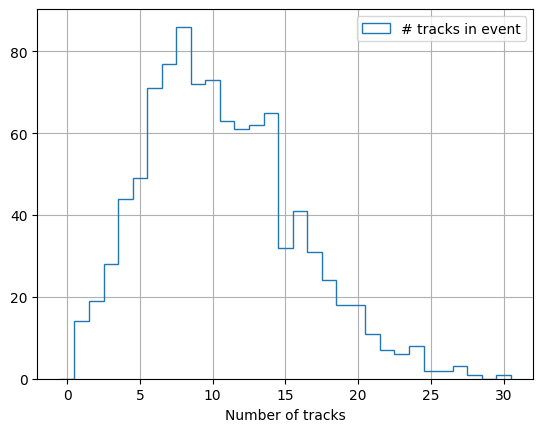

0.74107891549427


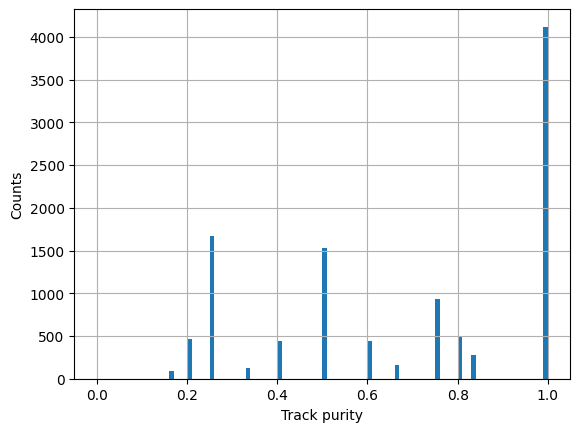

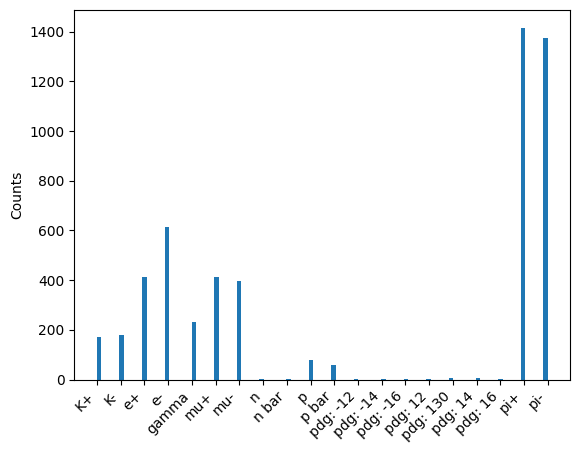

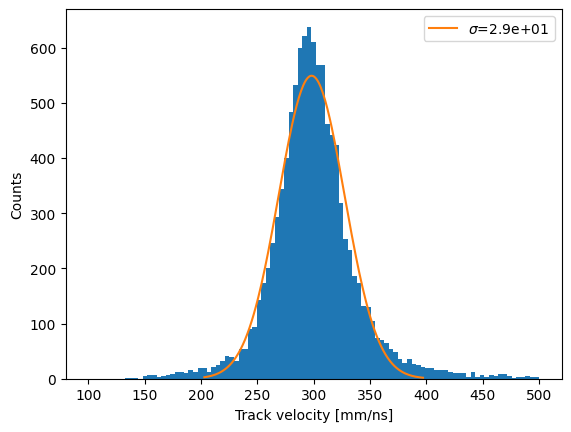

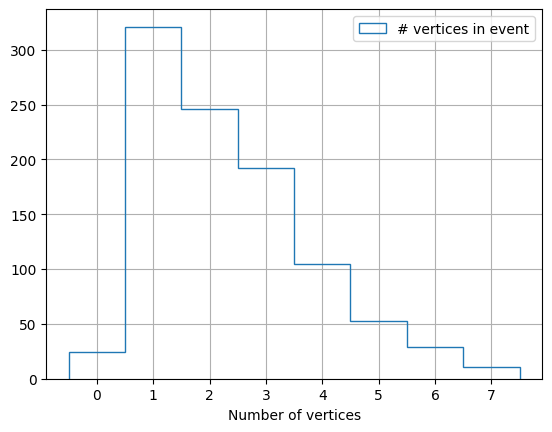

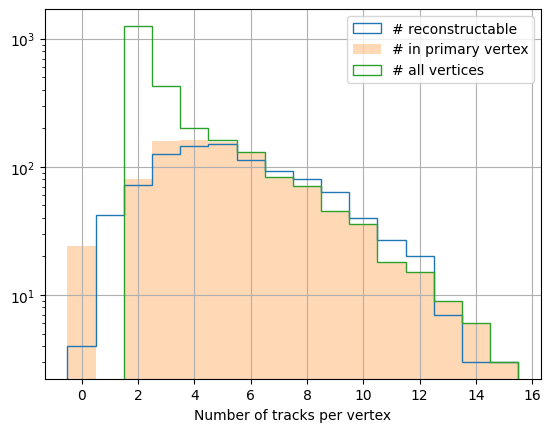

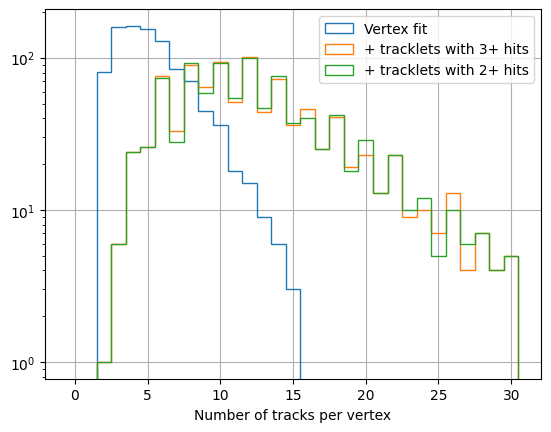

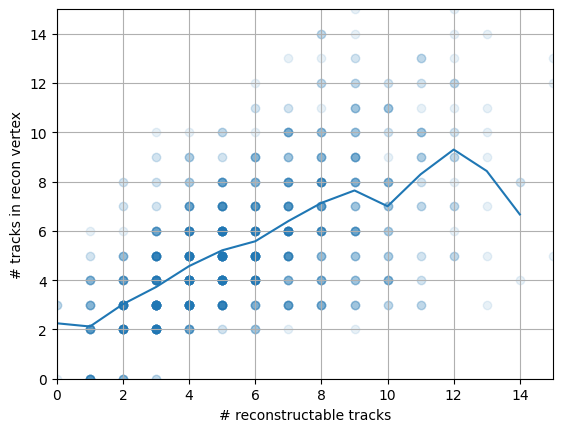

In [748]:
## Number of tracks
bins=np.linspace(-0.5,30.5,32)
plt.hist(res["event_ntracks"],bins=bins, histtype="step",label="# tracks in event");
plt.xlabel("Number of tracks")
plt.legend()
plt.grid()
plt.show()

## Track purity
print(sum(res["track_purity"]>=0.5)/len(res["track_purity"]))
plt.hist(res["track_purity"], bins=100,range=(0,1));
plt.xlabel("Track purity")
plt.ylabel("Counts")
plt.grid()
plt.show()

## Track particle types (of tracks used in primary vertex)
pdg_primary_track = res["track_pdg_str"][res["track_is_primary"]]
pdg_primary_track.sort()
plt.hist(pdg_primary_track,bins=100);
plt.xticks(rotation=45, ha='right');
plt.ylabel("Counts")
plt.show()

## Track velocity
bins=np.linspace(100,500,100)
mask_basic = (res["track_direction"]==2)
mask_pure = mask_basic & (res["track_purity"]==1)
mask_4hits = (res["track_direction"]==2) & (res["track_nhits"]==4)
h = plt.hist(res["track_vabs"],bins=bins);
popt, pcov, info, f = hp.fit_hist(hp.Gauss, h, 
                                  fit_range = [200,400], makeplot=True,
                                 p0=[max(h[0]), 300, 30], max_nfev=2000, label="$\sigma$={popt[2]:.1e}")
plt.ylabel("Counts")
plt.xlabel("Track velocity [mm/ns]")
plt.legend()
plt.show()

## Number of vertices
bins=np.linspace(-0.5,7.5,9)
plt.hist(res["event_nvertices"],bins=bins, histtype="step",label="# vertices in event");
plt.xlabel("Number of vertices")
plt.legend()
plt.grid()
plt.show()


## Number of tracks in vertex
bins=np.linspace(-0.5,15.5,17)
plt.hist(res["event_ntrack_reconstructable_primary"],bins=bins, histtype="step",label="# reconstructable");
plt.hist(res["event_vntrk_max"],bins=bins, alpha=0.3,label="# in primary vertex");
plt.hist(res["vertex_ntracks"],bins=bins, histtype="step",label="# all vertices");
plt.yscale("log")
plt.xlabel("Number of tracks per vertex")
plt.legend()
plt.grid()
plt.show()


## Number of tracks and tracklets in vertex
bins=np.linspace(-0.5,30.5,32)
mask = res["vertex_is_primary"]
plt.hist(res["vertex_ntracks"][mask],bins=bins, histtype="step",label="Vertex fit");
plt.hist((res["vertex_ntracks"]+res["vertex_ntracklet_3+"])[mask],bins=bins, histtype="step",label="+ tracklets with 3+ hits");
plt.hist((res["vertex_ntracks"]+res["vertex_ntracklet_2"]+res["vertex_ntracklet_3+"])[mask],bins=bins, histtype="step",label="+ tracklets with 2+ hits");
plt.yscale("log")
plt.xlabel("Number of tracks per vertex")
plt.legend()
plt.grid()
plt.show()


## Number of tracks in vertex
# plt.scatter(res["event_ntrack_reconstructable"],res["event_ntrack_recon"], alpha=0.2)
plt.scatter(res["event_ntrack_reconstructable_primary"],res["event_vntrk_max"], alpha=0.1)
xx = np.arange(15)
yy = []
for i in xx:
    yy.append(np.mean(res["event_vntrk_max"][res["event_ntrack_reconstructable_primary"]==i]))
plt.plot(xx,yy)
plt.xlim(0,15)
plt.ylim(0,15)
plt.xlabel("# reconstructable tracks")
plt.ylabel("# tracks in recon vertex")
plt.grid()
plt.show()

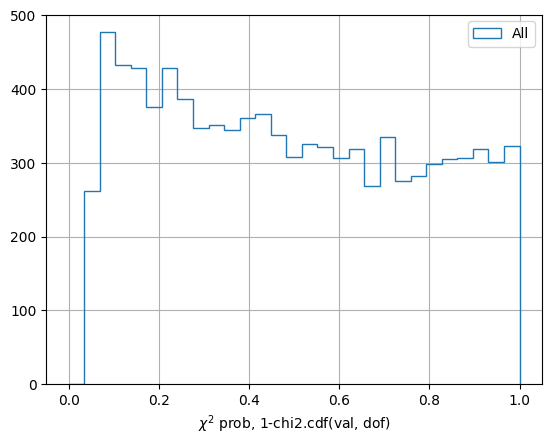

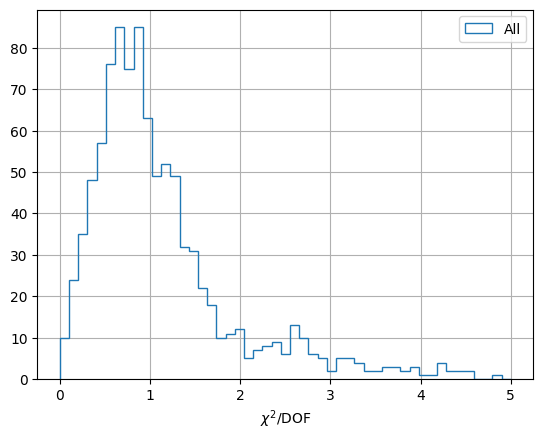

1.1257701558945261


In [739]:
## Tracks chi2 prob
bins=np.linspace(0,1,30)
plt.hist(1-res["track_prob"],bins=bins, histtype="step",label="All");
plt.xlabel(r"$\chi^2$ prob, 1-chi2.cdf(val, dof)")
plt.legend()
plt.grid()
plt.show()

## Vertex chi2 prob
# bins=np.linspace(0,1,50)
# mask_basic = (res["vertex_is_primary"])
# plt.hist(1-res["vertex_prob"],bins=bins, histtype="step",label="All");
# plt.hist((1-res["vertex_prob"])[mask_basic],bins=bins, histtype="step",label="All");
# plt.xlabel(r"$\chi^2$ prob, 1-chi2.cdf(val, dof)")
# plt.legend()
# plt.grid()
# plt.show()

bins=np.linspace(0,5,50)
mask_basic = (res["vertex_is_primary"])
plt.hist((res["vertex_chi2"]/(res["vertex_ntracks"]*3-4))[mask_basic],bins=bins, histtype="step",label="All");
plt.xlabel(r"$\chi^2$/DOF")
plt.legend()
plt.grid()
plt.show()

print(np.mean((res["vertex_chi2"]/(res["vertex_ntracks"]*3-4))[mask_basic]))

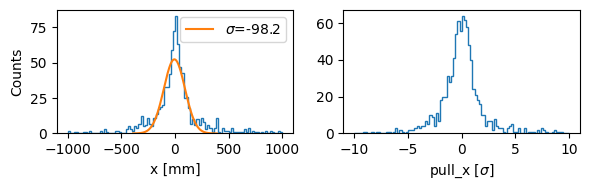

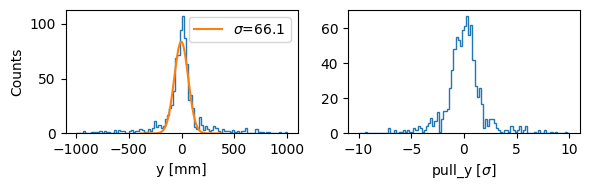

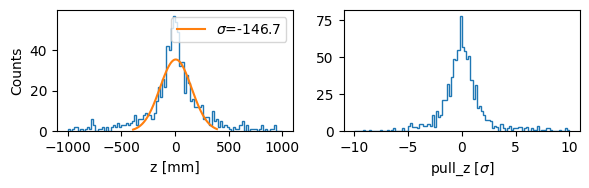

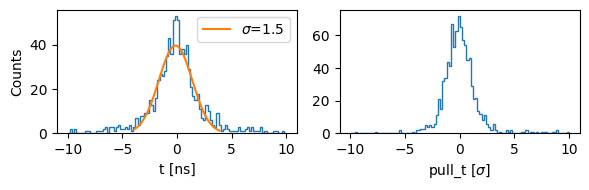

Text(0.5, 0, 'x [mm]')

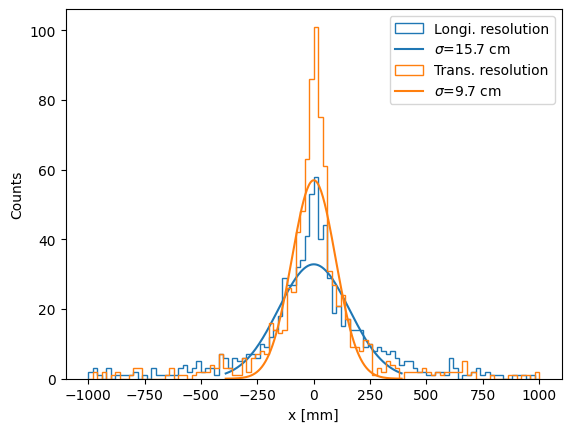

In [741]:
mask_basic = (res["vertex_is_primary"])
x=1000
plot_ranges = [[-x,x], [-x,x], [-x,x], [-10,10]]
plot_units = ["mm", "mm", "mm", "ns"]
plot_labels = ["x", "y", "z", "t"]

for i in range(4):
    fig,axs = plt.subplots(1,2,figsize=(6,2))
    plt.sca(axs[0])
    h = plt.hist((res["vertex_residual"][:,i])[mask_basic], bins=100, range=plot_ranges[i], histtype="step");
    popt, pcov, info, f = hp.fit_hist(hp.Gauss, h, 
                                      fit_range = [0.4*plot_ranges[i][0], 0.4*plot_ranges[i][1]], makeplot=True,
                                     p0=[max(h[0]), 0, np.std((res["vertex_residual"][:,i])[mask_basic])/4], max_nfev=2000, label="$\sigma$={popt[2]:.1f}")
    plt.ylabel("Counts")
    plt.legend()
    plt.xlabel(f"{plot_labels[i]} [{plot_units[i]}]")
    
    plt.sca(axs[1])
    plt.hist((res["vertex_residual"][:,i]/res["vertex_error"][:,i])[mask_basic], bins=100, range=(-10,10), histtype="step");
    plt.xlabel(f"pull_{plot_labels[i]} [$\sigma$]")
    plt.tight_layout()
    plt.show()
    # break


i=0
h = plt.hist((res["vertex_residual_longitrans"][:,0])[mask_basic], bins=100, range=plot_ranges[i], histtype="step", label="Longi. resolution");
popt, pcov, info, f = hp.fit_hist(hp.Gauss, h, 
                                  fit_range = [0.4*plot_ranges[i][0], 0.4*plot_ranges[i][1]], makeplot=True,
                                 p0=[max(h[0]), 0, np.std((res["vertex_residual"][:,i])[mask_basic])/4], max_nfev=2000, label="$\sigma$={popt[2]*0.1:.1f} cm", color="C0")

h = plt.hist((res["vertex_residual_longitrans"][:,2])[mask_basic], bins=100, range=plot_ranges[i], histtype="step", label="Trans. resolution");
popt, pcov, info, f = hp.fit_hist(hp.Gauss, h, 
                                  fit_range = [0.4*plot_ranges[i][0], 0.4*plot_ranges[i][1]], makeplot=True,
                                 p0=[max(h[0]), 0, np.std((res["vertex_residual"][:,i])[mask_basic])/4], max_nfev=2000, label="$\sigma$={popt[2]*0.1:.1f} cm", color="C1")

plt.ylabel("Counts")
plt.legend()
plt.xlabel(f"{plot_labels[i]} [{plot_units[i]}]")

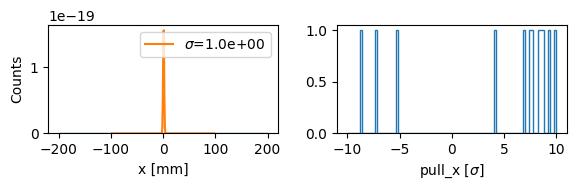

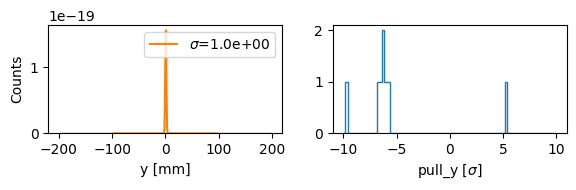

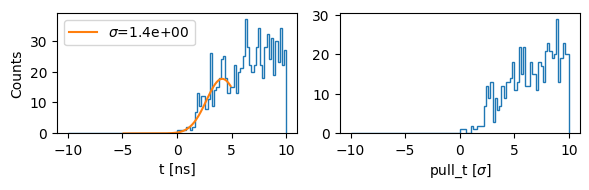

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

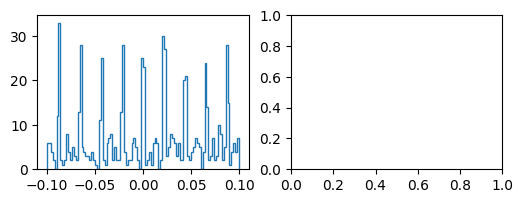

In [742]:
mask_basic = (res["track_direction"]==2)
mask_pure = mask_basic & (res["track_purity"]==1)
plot_ranges = [[-200,200], [-200,200], [-10,10], [-0.1,0.1], [-0.1,0.1], [-0.004,0.004]]
plot_units = ["mm", "mm", "ns", "mm/mm", "mm/mm", "ns/mm"]
plot_labels = ["x", "y", "t", "kx", "ky", "kt"]

for i in range(6):
    fig,axs = plt.subplots(1,2,figsize=(6,2))
    plt.sca(axs[0])
    h=plt.hist((res["track_residual_6d"][:,i])[mask_basic], bins=100, range=plot_ranges[i], histtype="step");
    # plt.hist((res["track_residual_6d"][:,i])[mask_pure], bins=100, range=plot_ranges[i], histtype="step");
    popt, pcov, info, f = hp.fit_hist(hp.Gauss, h, 
                                      fit_range = [0.5*plot_ranges[i][0], 0.5*plot_ranges[i][1]], makeplot=True,
                                     p0=None, max_nfev=2000, label="$\sigma$={popt[2]:.1e}")
    plt.ylabel("Counts")
    plt.legend()
    plt.xlabel(f"{plot_labels[i]} [{plot_units[i]}]")
    
    plt.sca(axs[1])
    plt.hist((res["track_residual_6d"][:,i]/res["track_error_6d"][:,i])[mask_basic], bins=100, range=(-10,10), histtype="step");
    plt.xlabel(f"pull_{plot_labels[i]} [$\sigma$]")
    plt.tight_layout()
    plt.show()



In [323]:
def update_Q(dy, Ax, Az, At, multiple_scattering_p=500, multiple_scattering_length=0.06823501107481977):

    # precalculate some numbers
    Ax2 = Ax**2
    Az2 = Az**2
    At2 = At**2
    dy2 = dy**2
    P4P5 = (1+Ax2+Az2)
    P4P52 = P4P5*P4P5
    sin_theta = np.power(Ax**2+Az**2+1, -1/2)
    
    # Q_block1 = np.array([[(1+Ax2)*P4P5,      Ax*Az*P4P5 , Ax*P4P52*At],
    #                      [  Ax*Az*P4P5,    (1+Az2)*P4P5,  Az*P4P52*At],
    #                      [ Ax*P4P52*At,    Az*P4P52*At,   (Ax2+Az2)*P4P52*At2]])
    print(sin_theta)
    Q_block1 = np.array([[(1+Ax2)*P4P5,      Ax*Az*P4P5 , Ax*P4P5**0.5*At],
                         [  Ax*Az*P4P5,    (1+Az2)*P4P5,  Az*P4P5**0.5*At],
                         [ Ax*P4P5**0.5*At,    Az*P4P5**0.5*At,   (Ax2+Az2)*At2]])    
            
    Q = np.block([[Q_block1*dy2, Q_block1*dy],
                  [Q_block1*dy , Q_block1]])      

    sigma_ms2 = scattering_angle(multiple_scattering_length/sin_theta, momentum_MeV=multiple_scattering_p)**2
    print(sigma_ms2)
    
    Q = Q*sigma_ms2
    return Q


def update_Q_partial(dy, Ax, Az, At, multiple_scattering_p=500, multiple_scattering_length=0.06823501107481977):

    # precalculate some numbers
    Ax2 = Ax**2
    Az2 = Az**2
    At2 = At**2
    dy2 = dy**2
    P4P5 = (1+Ax2+Az2)
    P4P52 = P4P5*P4P5
    sin_theta = np.power(Ax**2+Az**2+1, -1/2)

    Q_block1 = dy2 * np.array([[(1+Ax2)*P4P5,      Ax*Az*P4P5 , Ax*P4P52*At],
                         [  Ax*Az*P4P5,    (1+Az2)*P4P5,  Az*P4P52*At],
                         [ Ax*P4P52*At,    Az*P4P52*At,   (Ax2+Az2)*P4P52*At2]])        

    sigma_ms2 = track.scattering_angle(multiple_scattering_length/sin_theta, momentum_MeV=multiple_scattering_p)**2

    Q_block1 = Q_block1*sigma_ms2
    return Q_block1        


def scattering_angle(l_rad_relative, momentum_MeV):
    sigma_ms = 13.6 * np.sqrt(l_rad_relative) * (1 + 0.038 * np.log(l_rad_relative)) / momentum_MeV; #
    return sigma_ms 


In [324]:
update_Q(10000, 0.1, 0.3, 0.003)

0.9534625892455922
4.286692975989267e-05


array([[4.763e+03, 1.415e+02, 1.349e+00, 4.763e-01, 1.415e-02, 1.349e-04],
       [1.415e+02, 5.140e+03, 4.244e+00, 1.415e-02, 5.140e-01, 4.244e-04],
       [1.349e+00, 4.244e+00, 3.858e-03, 1.349e-04, 4.244e-04, 3.858e-07],
       [4.763e-01, 1.415e-02, 1.349e-04, 4.763e-05, 1.415e-06, 1.349e-08],
       [1.415e-02, 5.140e-01, 4.244e-04, 1.415e-06, 5.140e-05, 4.244e-08],
       [1.349e-04, 4.244e-04, 3.858e-07, 1.349e-08, 4.244e-08, 3.858e-11]])

In [118]:
def get_same_invar_pos_and_cov(point, track: Track):

    dt = point[track.iv_index] - track.params_full[track.iv_index];
    pos_on_track = track.params[:3] + track.params[3:] * dt;
    pos_full = np.insert(pos_on_track, track.iv_index, point[track.iv_index]);
    cov_residual = track.cov[:3, :3] + \
                   track.cov[:3, 3:] * dt +\
                   track.cov[3:, :3] * dt +\
                   track.cov[3:, 3:] * dt * dt;

    return pos_full, cov_residual

# def get_same_time_dist_and_chi2(Vector4d point, double speed_constraint):
#     auto point_and_cov = get_same_time_pos_and_cov(point, speed_constraint);
#     Vector3d residual = point_and_cov.first.segment(0,3) - point.segment(0, 3);
#     double dist_point = residual.norm();
#     double chi2_point = residual.transpose() * point_and_cov.second.inverse() * residual;

#     return std::make_pair(dist_point, chi2_point);


In [122]:
point = np.array([data["Gen_x"][0], data["Gen_y"][0], data["Gen_z"][0], data["Gen_t"][0]])
# point +=[8000,-5000,3000,1]
point

array([-11167.925,  14237.491,   2604.494,      0.   ])

In [171]:
track.GetTrack(data,6)
track.params, track.nhits, track.cov

(array([-7.450e+03,  1.435e+04,  3.565e+01,  5.469e-01,  6.562e-02,  3.754e-03]),
 4,
 array([[ 1.787e+00,  1.499e-06,  6.045e-04, -6.709e-04, -2.811e-09, -9.445e-07],
        [ 1.499e-06,  1.000e+00,  5.603e-09, -1.874e-09, -3.125e-04, -8.755e-12],
        [ 6.045e-04,  5.603e-09,  6.176e-01, -7.556e-07, -1.051e-11, -1.838e-04],
        [-6.709e-04, -1.874e-09, -7.556e-07,  4.481e-07,  3.514e-12,  1.181e-09],
        [-2.811e-09, -3.125e-04, -1.051e-11,  3.514e-12,  1.953e-07,  1.642e-14],
        [-9.445e-07, -8.755e-12, -1.838e-04,  1.181e-09,  1.642e-14,  9.192e-08]]))

In [169]:
3.095e-07  * 1e8 * 20

619.0

In [157]:
get_same_invar_pos_and_cov(point, track)

(array([-1.118e+04,  1.412e+04,  2.604e+03,  1.081e+01]),
 array([[3.739e+01, 4.282e-03, 6.159e-02],
        [4.282e-03, 1.173e+02, 3.362e-05],
        [6.159e-02, 3.362e-05, 2.357e+01]]))

In [113]:
cov=np.array([[    416.569,  -0.0036817,     1.26027],
            [ -0.0036817,     143.347, -1.2199e-05],
            [    1.26027, -1.2199e-05,     28.8281]])
residual=np.array([1112.66, 373.865, 1.02429])
residual.dot(np.linalg.inv(cov)).dot(residual)

3947.2493633909903

In [114]:
np.linalg.inv(cov)

array([[ 2.401e-03,  6.165e-08, -1.050e-04],
       [ 6.165e-08,  6.976e-03,  2.567e-10],
       [-1.050e-04,  2.567e-10,  3.469e-02]])

In [2]:
import scipy

In [16]:
def drop_hit_prob(nhits, prob_single):
    nmin = 4
    p = 0
    for k in range(nmin,nhits+1)[::-1]:
        p += prob_single**k *  (1-prob_single)**(nhits-k) * scipy.special.comb(nhits, nhits-k)
    return p

---
# Check if the reproduced events are the same as before

In [566]:
data_dir="../../../musim_test/recon_llp/"
fname_recon_reproduce = f"{data_dir}/run_1_digi_recon.root"

In [646]:
f2 = root.tfile_reader(fname_recon_reproduce)
f2.ls()

## Get metadata
f2.get_tree("metadata;2")
# f1.ls_tree()
metadata_digi = f2.get_entry(0)

f2.get_tree("data")
# f1.ls_tree()
f2.get_entry(0);

None
TFile**		../../../musim_test/recon_llp//run_1_digi_recon.root	
 TFile*		../../../musim_test/recon_llp//run_1_digi_recon.root	
  KEY: TTree	data;1	Reconstruction Tree
  KEY: TTree	metadata;3	Simulation metadata [current cycle]
  KEY: TTree	metadata;2	Metadata for digitization [backup cycle]
  KEY: TTree	metadata;1	Metadata for reconstruction [backup cycle]


In [647]:
data1.keys()

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_edep', 'Hit_px', 'Hit_py', 'Hit_pz', 'Hit_trackID', 'Hit_trackIDparent', 'Hit_pdgID', 'Hit_pdgIDparent', 'Hit_isprimary', 'Hit_processID', 'Hit_detectorID', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Step_x', 'Step_y', 'Step_z', 'Step_t', 'Step_edep', 'Step_px', 'Step_py', 'Step_pz', 'Step_trackID', 

In [657]:
# Check that two files are equal
for i in range(f1.entries):
    data1 = f1.get_entry(i)
    data2 = f2.get_entry(i)
    
    assert data1["Seed_0"]==data2["Seed_0"]
    assert (np.array(data1["Gen_px"])-np.array(data2["Gen_px"])==0 ).all()
    assert (np.array(data1["Hit_x"])-np.array(data2["Hit_x"])==0).all()

99


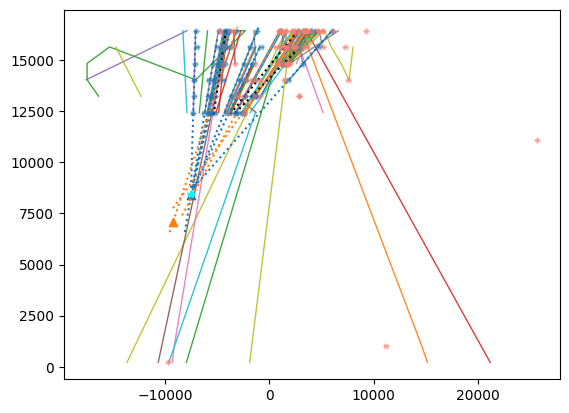

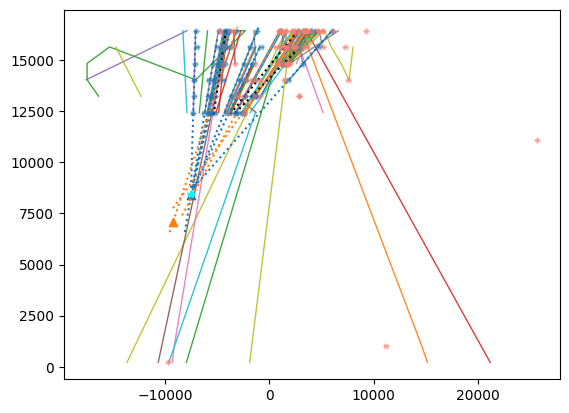

In [575]:
i=99
print(i)

data1 = f1.get_entry(i)
event = datatypes.Event(data1, metadata_digi)  
event.plot_truetracks(0,2)
event.plot_digis(0,2)
event.plot_vertex(0,2,lim_x=26000, lim_y=1e9)
event.genvertices.plot(0,2)
plt.show()    


data2 = f2.get_entry(i)
event = datatypes.Event(data2, metadata_digi)  
event.plot_truetracks(0,2)
event.plot_digis(0,2)
event.plot_vertex(0,2,lim_x=26000, lim_y=1e9)
event.genvertices.plot(0,2)
plt.show()    